In [1]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.activations import relu, softmax
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import Sequential
from keras.utils import to_categorical, multi_gpu_model
from keras.applications import VGG16
from keras.optimizers import adam
from keras.preprocessing import image
from keras.optimizers import Adam, RMSprop
from keras.datasets import mnist
from keras.backend import image_data_format
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras_tqdm import TQDMNotebookCallback
from matplotlib import pyplot as plt
from keras.backend import clear_session
import numpy as np
from numba import cuda

from keras.utils import vis_utils
from time import time


from random import sample

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data = mnist.load_data()

X_train = data[0][0]
X_test = data[1][0]
y_train = data[0][1]
y_test = data[1][1]

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


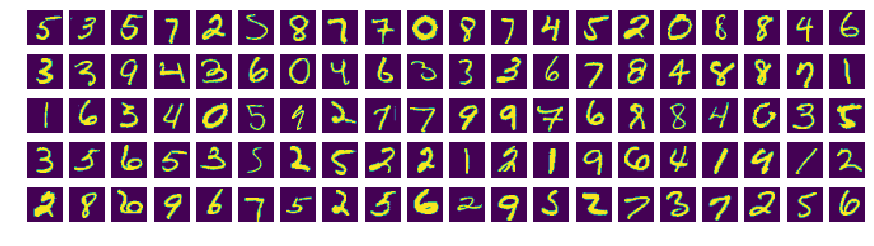

In [4]:
a = sample(list(X_train),201)#
#a[0]

plt.figure(figsize=(15,8))
for i in range(1,101):
    axis = plt.subplot(10,20,i)
    plt.imshow((a[i]))
    plt.axis('Off')



In [5]:
# convert to categorical and scale X data 

y_train = to_categorical(y_train,num_classes=10)
y_test = to_categorical(y_test,num_classes=10)

X_train = X_train/255.0
X_test = X_test/255.0

X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

In [6]:
import keras.backend as K
K.clear_session()

cuda.select_device(0)
cuda.close()

In [6]:

model = Sequential()

if image_data_format() == 'channels_last':
    model.add(Conv2D(128,kernel_size=(5,5),input_shape=(28,28,1),activation='relu',padding='same'))
else:
    model.add(Conv2D(128,kernel_size=(5,5),input_shape=(3,28,28),activation='relu'))


model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(5,5),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.4))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
#model.add(MaxPool2D(pool_size=(2,2)))

#model.add(Conv2D(16,kernel_size=(3,3),activation='relu'))
#model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
    #model.add(Dense(1024))
model.add(Dense(512))
model.add(Dense(64))
model.add(Dense(10,activation='softmax'))

In [7]:
vis_utils.plot_model(model,to_file='b.jpg',show_shapes=True,show_layer_names=False)


In [8]:

# Callbacks

model = multi_gpu_model(model,gpus=2)
model.name = '2'
stoppage = EarlyStopping(monitor='val_loss',patience=4)

#tensorboard visualization
tb = TensorBoard(log_dir='/mnt/HDD/vishnu/logo/{}'.format(time()),histogram_freq=1,write_grads=True, write_images=True,
                embeddings_metadata=True)

model.compile(optimizer='RMSprop',loss='categorical_crossentropy',metrics=['acc'])



In [10]:
history = model.fit(x=X_train, y= y_train, validation_split=0.2,epochs=100, batch_size=64, callbacks=[tb,stoppage])

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 10s 217us/step - loss: 0.0396 - acc: 0.9883 - val_loss: 0.0347 - val_acc: 0.9900
Epoch 2/100
48000/48000 [==============================] - 10s 206us/step - loss: 0.0377 - acc: 0.9892 - val_loss: 0.0367 - val_acc: 0.9902
Epoch 3/100
48000/48000 [==============================] - 10s 211us/step - loss: 0.0370 - acc: 0.9890 - val_loss: 0.0417 - val_acc: 0.9890
Epoch 4/100
48000/48000 [==============================] - 10s 210us/step - loss: 0.0328 - acc: 0.9899 - val_loss: 0.0527 - val_acc: 0.9868
Epoch 5/100
48000/48000 [==============================] - 10s 211us/step - loss: 0.0320 - acc: 0.9909 - val_loss: 0.0439 - val_acc: 0.9913


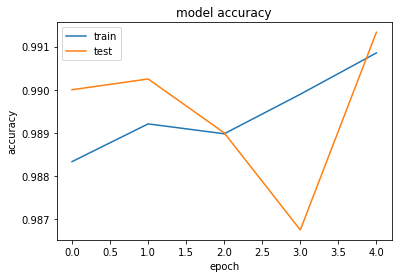

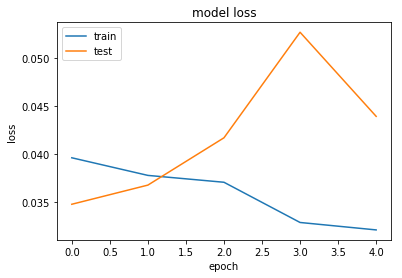

In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<b>Observations:</b>
    1. To avoid overfitting data augumentation, add dropout layer and add baises.
    2. Use tensorboard visualization and add batch normalization if gradients are vanishing/ exploiting. 